# COMP47590: Advanced Machine Learning
# Assignment 1: Building Stacked Ensembles

## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

#from TAS_Python_Utilities import data_viz
#from TAS_Python_Utilities import data_viz_target
#from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import itertools
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#%qtconsole

# General Utility Functions

In [0]:
classes_fashion     = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
                       'Sandal','Shirt','Sneaker','Bag','Ankle boot']

def plot_confusion_matrix(cm,class_,title='Confusion matrix',cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()



In [0]:
def eval_model(model,X_train,y_train,d={} ,model_name = "",base_classifier = ""):
    # Make a set of predictions for the test data
    y_pred = model.predict(X_train)
    
    # Print performance details
    accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
    print("Accuracy: " +  str(accuracy * 100))


    # Print performance details
    print(metrics.classification_report(y_train, y_pred))

    # Print confusion matrix
    print("Confusion Matrix")
    print(model_name)
    plot_confusion_matrix(confusion_matrix(y_train, y_pred), classes_fashion)
    if model_name != "":
        d[model_name + ","+base_classifier] = str(accuracy * 100)
        return d
    else:
      return
    
    
    
    

In [0]:
def report(header, dtrain, dtest, table):
  table.field_names = header
  for k,v in dtrain.items():
    a = []
    a = k.split(',')
    table.add_row([a[0], a[1], v, dtest[k]])
  
  print(table)
  
  
def reportcv(header, dtrain, dtest, table):
  table.field_names = header
  for k,v in dtrain.items():
    a = []
    a = k.split(',')
    table.add_row([a[0], a[1], v, dtest[k]])
  
  print(table)
    
  
  

# Dataset Loading

# NOTE

#### Some of the cells have been commented out since these have been use to load original dataset and to sample the same

In [0]:
#df = pd.read_csv('fashion-mnist_train.csv')

In [0]:
#df.shape

(60000, 785)

In [0]:
#df = df.sample(frac = 0.03)

In [0]:
#df.to_csv('fashion-mnist.csv', encoding='utf-8',index = False)

In [2]:
df = pd.read_csv('fashion-mnist.csv')

In [3]:
df.shape

(1800, 785)

In [0]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,4,0,0,0,0,1,0,0,0,1,...,0,0,144,161,92,60,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,144,173,56,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:

df["label"].value_counts()

1    193
6    185
9    183
2    183
4    182
3    181
0    180
7    177
8    168
5    168
Name: label, dtype: int64

In [0]:
X = df[df.columns[1:]]
Y = np.array(df["label"])

In [0]:
X = X/255

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, random_state=0, train_size = 0.8)


In [0]:
df_test = pd.read_csv('fashion-mnist_test.csv')

In [0]:
X_test = df_test[df_test.columns[1:]]
Y_test = np.array(df_test["label"])
X_test = X_test/255           

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [0]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Task 1: Design the StackedEnsembleHoldOut Class

In [0]:
# Write your code here
class StackedEnsembleClassifierHoldOut(BaseEstimator, ClassifierMixin):
  """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 8)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem)."""
  
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        self.n_estimators_ = len(self.classifiers_)
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #splitting the train and test data with 70:30 ratio 
        
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test
        
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_test) #prediction on the test data

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
                
        
         ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))#training on the prediction of test data

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self
    
    
    def predict(self, X):
        
        check_is_fitted(self, ['stack_layer_classifier_'])
        X = check_array(X)
        X_stack_queries = None
        
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
                
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    
    
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)
    
    
    
                
                
    
        
        
    

In [0]:
stack_ensemble_clf = StackedEnsembleClassifier()

In [207]:
stack_ensemble_clf.fit(X_train,y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='logreg')

Accuracy: 80.83333333333333
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        39
           1       1.00      0.93      0.97        46
           2       0.65      0.65      0.65        31
           3       0.78      0.88      0.82        32
           4       0.67      0.69      0.68        35
           5       0.82      0.93      0.87        30
           6       0.47      0.50      0.49        38
           7       0.94      0.87      0.91        39
           8       0.91      0.94      0.93        34
           9       0.94      0.92      0.93        36

   micro avg       0.81      0.81      0.81       360
   macro avg       0.81      0.81      0.81       360
weighted avg       0.81      0.81      0.81       360

Confusion Matrix



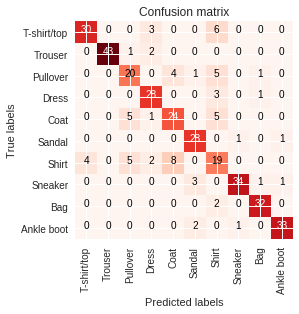

In [208]:
eval_model(stack_ensemble_clf,X_valid,y_valid)

Accuracy: 81.17
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1000
           1       0.94      0.95      0.94      1000
           2       0.73      0.71      0.72      1000
           3       0.78      0.86      0.82      1000
           4       0.75      0.71      0.73      1000
           5       0.90      0.87      0.89      1000
           6       0.56      0.56      0.56      1000
           7       0.87      0.85      0.86      1000
           8       0.94      0.93      0.93      1000
           9       0.87      0.93      0.90      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix



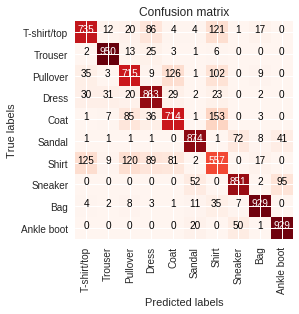

In [209]:
eval_model(stack_ensemble_clf,X_test,Y_test)

## Task 2: Design the StackedEnsembleKFold Class

In [0]:
# Write your code here
class StackedEnsembleClassifierKFold(BaseEstimator, ClassifierMixin):
   """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 8)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    folds: int, optional (default = 3)
        How many folds will be used to generate the training set for the stacked layer
    
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem)."""
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg", folds = 3):
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.folds = folds
        
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.classifiers_ = list()
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
                
        self.n_estimators_ = len(self.classifiers_)
        
        kfold = StratifiedKFold(n_splits= self.folds) # splitting the data into folds to generate training and validation data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = np.array([])
        
        
        
        
        for train_index, test_index in kfold.split(X, y):# iterating through each folds to train the base model
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            
            self.y_stack_train = np.r_[self.y_stack_train, y_test]
            
            X_stack_train_fold = None
            
            for classifier in self.classifiers_:
                X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)
                
                classifier.fit(X_train_samp, y_train_samp)
                
                y_pred = classifier.predict_proba(X_test)
                
                
                try:
                    X_stack_train_fold = np.c_[X_stack_train_fold, y_pred]
                except ValueError:
                    X_stack_train_fold = y_pred
                    
                    
            try:
                self.X_stack_train = np.r_[self.X_stack_train, X_stack_train_fold]
            except ValueError:
                self.X_stack_train = X_stack_train_fold
                
                
            self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))
            
            self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
            
            # traing on the whole dataset
            self.classifiers_ = list()
            for i in range(0, self.base_estimator_duplicates):
                for t in self.base_estimator_types:

                    self.base_estimator_type_list.append(t)      
                    c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                    X_samp, y_samp = resample(X, y, replace=True)
                    c.fit(X_samp, y_samp )
                    self.classifiers_.append(c)
        return self
    
    
    
    def predict(self, X):
        
        check_is_fitted(self, ['stack_layer_classifier_'])
        X = check_array(X)
        X_stack_queries = None
        
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
                
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    
    
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)
        

In [0]:
stack_ensemble_clf = StackedEnsembleClassifierKFold()

In [211]:
stack_ensemble_clf.fit(X_train,y_train)

StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                base_estimator_types=['svm', 'logreg', 'tree'], folds=3,
                stack_layer_classifier_type='logreg')

Accuracy: 77.22222222222223
              precision    recall  f1-score   support

           0       0.87      0.67      0.75        39
           1       0.98      0.93      0.96        46
           2       0.52      0.48      0.50        31
           3       0.72      0.81      0.76        32
           4       0.67      0.74      0.70        35
           5       0.79      0.90      0.84        30
           6       0.45      0.47      0.46        38
           7       0.87      0.85      0.86        39
           8       0.89      0.91      0.90        34
           9       0.94      0.92      0.93        36

   micro avg       0.77      0.77      0.77       360
   macro avg       0.77      0.77      0.77       360
weighted avg       0.78      0.77      0.77       360

Confusion Matrix



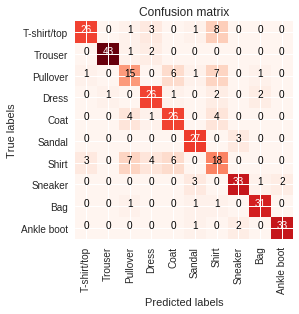

In [212]:
eval_model(stack_ensemble_clf,X_valid,y_valid)

Accuracy: 80.15
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1000
           1       0.92      0.96      0.94      1000
           2       0.74      0.67      0.70      1000
           3       0.77      0.85      0.81      1000
           4       0.72      0.72      0.72      1000
           5       0.85      0.87      0.86      1000
           6       0.54      0.57      0.55      1000
           7       0.85      0.85      0.85      1000
           8       0.93      0.93      0.93      1000
           9       0.90      0.90      0.90      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Confusion Matrix



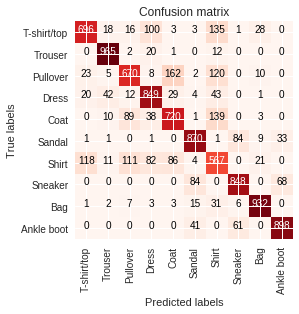

In [213]:
eval_model(stack_ensemble_clf,X_test,Y_test)

## Task 3: Compare the Performance of Different Stack Layer Approaches

In [ ]:
d_valid = {}
d_test = {}

In [0]:
stack_ensemble_clf = StackedEnsembleClassifier() 

In [0]:
stack_ensemble_clf.fit(X_train,y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='logreg')

Accuracy: 0.7888888888888889
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        39
           1       0.98      0.93      0.96        46
           2       0.63      0.61      0.62        31
           3       0.77      0.84      0.81        32
           4       0.64      0.66      0.65        35
           5       0.85      0.97      0.91        30
           6       0.40      0.45      0.42        38
           7       0.92      0.85      0.88        39
           8       0.91      0.94      0.93        34
           9       0.94      0.92      0.93        36

   micro avg       0.79      0.79      0.79       360
   macro avg       0.79      0.79      0.79       360
weighted avg       0.80      0.79      0.79       360

Confusion Matrix


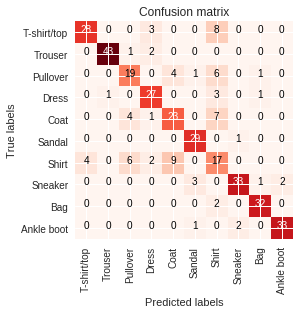

In [0]:
d_valid = eval_model(stack_ensemble_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifier","logreg")

Accuracy: 0.8076
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1000
           1       0.94      0.94      0.94      1000
           2       0.71      0.70      0.71      1000
           3       0.78      0.87      0.82      1000
           4       0.71      0.71      0.71      1000
           5       0.88      0.87      0.88      1000
           6       0.55      0.54      0.55      1000
           7       0.86      0.85      0.86      1000
           8       0.95      0.93      0.94      1000
           9       0.88      0.92      0.90      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix


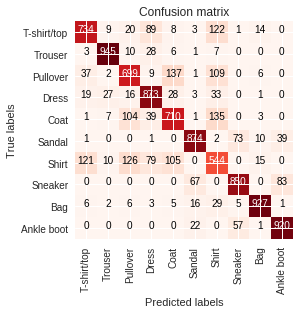

In [0]:
d_test = eval_model(stack_ensemble_clf,X_test,Y_test,d_test,"StackedEnsembleClassifier","logreg")

In [0]:
stack_ensemble_holdout_clf = StackedEnsembleClassifierHoldOut()

In [0]:
stack_ensemble_holdout_clf.fit(X_train,y_train)

StackedEnsembleClassifierHoldOut(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 stack_layer_classifier_type='logreg')

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        39
           1       0.98      0.93      0.96        46
           2       0.67      0.58      0.62        31
           3       0.71      0.84      0.77        32
           4       0.65      0.49      0.56        35
           5       0.80      0.93      0.86        30
           6       0.39      0.53      0.45        38
           7       0.82      0.85      0.84        39
           8       0.91      0.91      0.91        34
           9       0.97      0.86      0.91        36

   micro avg       0.77      0.77      0.77       360
   macro avg       0.78      0.76      0.77       360
weighted avg       0.78      0.77      0.77       360

Confusion Matrix


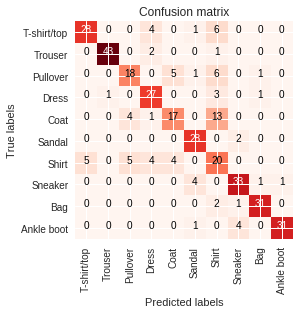

In [0]:
d_valid = eval_model(stack_ensemble_holdout_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierHoldOut","logreg")

Accuracy: 0.7871
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1000
           1       0.92      0.95      0.94      1000
           2       0.69      0.69      0.69      1000
           3       0.77      0.84      0.80      1000
           4       0.75      0.56      0.65      1000
           5       0.88      0.88      0.88      1000
           6       0.46      0.59      0.52      1000
           7       0.83      0.87      0.85      1000
           8       0.94      0.93      0.93      1000
           9       0.90      0.89      0.90      1000

   micro avg       0.79      0.79      0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

Confusion Matrix


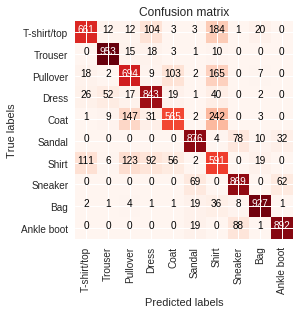

In [0]:
d_test = eval_model(stack_ensemble_holdout_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierHoldOut","logreg")

In [0]:
stack_ensemble_kfold_clf = StackedEnsembleClassifierKFold()

In [0]:
stack_ensemble_kfold_clf.fit(X_train,y_train)

StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                base_estimator_types=['svm', 'logreg', 'tree'], folds=3,
                stack_layer_classifier_type='logreg')

Accuracy: 0.7722222222222223
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        39
           1       0.98      0.93      0.96        46
           2       0.53      0.52      0.52        31
           3       0.78      0.88      0.82        32
           4       0.63      0.69      0.66        35
           5       0.74      0.97      0.84        30
           6       0.40      0.37      0.38        38
           7       0.91      0.82      0.86        39
           8       0.91      0.94      0.93        34
           9       0.97      0.89      0.93        36

   micro avg       0.77      0.77      0.77       360
   macro avg       0.77      0.77      0.77       360
weighted avg       0.77      0.77      0.77       360

Confusion Matrix


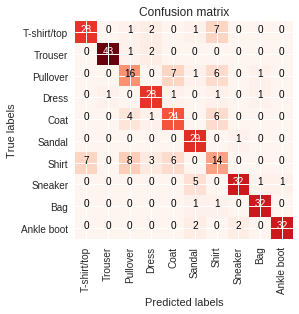

In [0]:
d_valid = eval_model(stack_ensemble_kfold_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierKFold","logreg")

Accuracy: 0.8005
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1000
           1       0.93      0.95      0.94      1000
           2       0.72      0.67      0.70      1000
           3       0.75      0.86      0.80      1000
           4       0.72      0.70      0.71      1000
           5       0.89      0.88      0.88      1000
           6       0.53      0.56      0.54      1000
           7       0.85      0.85      0.85      1000
           8       0.93      0.94      0.94      1000
           9       0.89      0.90      0.90      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Confusion Matrix


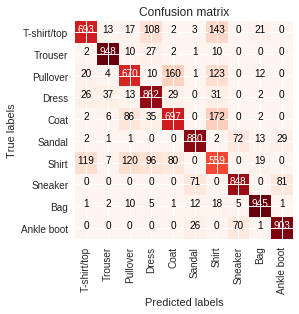

In [0]:
d_test = eval_model(stack_ensemble_kfold_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierKFold","logreg")

In [0]:
stack_ensemble_clf = StackedEnsembleClassifier(stack_layer_classifier_type = "svm")

In [0]:
stack_ensemble_clf.fit(X_train,y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='svm')

Accuracy: 0.7972222222222223
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        39
           1       1.00      0.93      0.97        46
           2       0.60      0.58      0.59        31
           3       0.77      0.84      0.81        32
           4       0.62      0.60      0.61        35
           5       0.82      0.93      0.87        30
           6       0.50      0.55      0.53        38
           7       0.87      0.85      0.86        39
           8       0.91      0.94      0.93        34
           9       0.97      0.92      0.94        36

   micro avg       0.80      0.80      0.80       360
   macro avg       0.80      0.79      0.79       360
weighted avg       0.80      0.80      0.80       360

Confusion Matrix


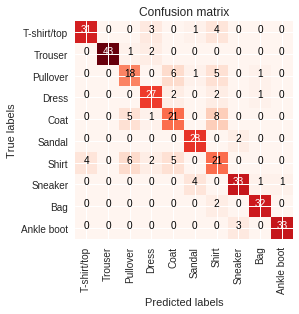

In [0]:
d_valid = eval_model(stack_ensemble_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifier","svm")

Accuracy: 0.8111
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1000
           1       0.96      0.94      0.95      1000
           2       0.73      0.70      0.71      1000
           3       0.77      0.88      0.82      1000
           4       0.72      0.73      0.72      1000
           5       0.90      0.87      0.88      1000
           6       0.55      0.57      0.56      1000
           7       0.85      0.88      0.86      1000
           8       0.95      0.93      0.94      1000
           9       0.90      0.91      0.90      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix


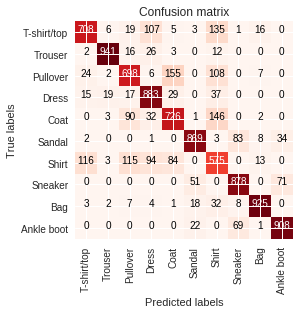

In [0]:
d_test = eval_model(stack_ensemble_clf,X_test,Y_test,d_test,"StackedEnsembleClassifier","svm")

In [0]:
stack_ensemble_holdout_clf = StackedEnsembleClassifierHoldOut(stack_layer_classifier_type = "svm")

In [0]:
stack_ensemble_holdout_clf.fit(X_train,y_train)

StackedEnsembleClassifierHoldOut(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 stack_layer_classifier_type='svm')

Accuracy: 0.7611111111111111
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        39
           1       1.00      0.91      0.95        46
           2       0.61      0.45      0.52        31
           3       0.73      0.84      0.78        32
           4       0.62      0.43      0.51        35
           5       0.83      0.97      0.89        30
           6       0.35      0.58      0.44        38
           7       0.89      0.87      0.88        39
           8       0.94      0.88      0.91        34
           9       0.97      0.92      0.94        36

   micro avg       0.76      0.76      0.76       360
   macro avg       0.78      0.76      0.76       360
weighted avg       0.79      0.76      0.77       360

Confusion Matrix


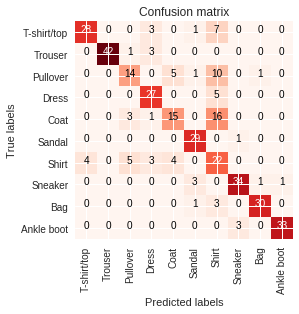

In [0]:
d_valid = eval_model(stack_ensemble_holdout_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierHoldOut","svm")

Accuracy: 0.7833
              precision    recall  f1-score   support

           0       0.84      0.70      0.76      1000
           1       0.97      0.92      0.95      1000
           2       0.76      0.64      0.69      1000
           3       0.76      0.86      0.81      1000
           4       0.79      0.50      0.61      1000
           5       0.90      0.88      0.89      1000
           6       0.40      0.66      0.50      1000
           7       0.85      0.87      0.86      1000
           8       0.96      0.89      0.92      1000
           9       0.89      0.90      0.90      1000

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.81      0.78      0.79     10000
weighted avg       0.81      0.78      0.79     10000

Confusion Matrix


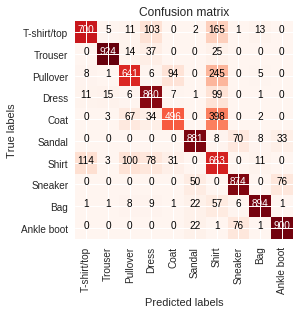

In [0]:
d_test = eval_model(stack_ensemble_holdout_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierHoldOut","svm")

In [0]:
stack_ensemble_kfold_clf = StackedEnsembleClassifierKFold(stack_layer_classifier_type = "svm")

In [0]:
stack_ensemble_kfold_clf.fit(X_train,y_train)

StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                base_estimator_types=['svm', 'logreg', 'tree'], folds=3,
                stack_layer_classifier_type='svm')

Accuracy: 0.7972222222222223
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        39
           1       1.00      0.93      0.97        46
           2       0.60      0.58      0.59        31
           3       0.77      0.84      0.81        32
           4       0.62      0.60      0.61        35
           5       0.82      0.93      0.87        30
           6       0.50      0.55      0.53        38
           7       0.87      0.85      0.86        39
           8       0.91      0.94      0.93        34
           9       0.97      0.92      0.94        36

   micro avg       0.80      0.80      0.80       360
   macro avg       0.80      0.79      0.79       360
weighted avg       0.80      0.80      0.80       360

Confusion Matrix


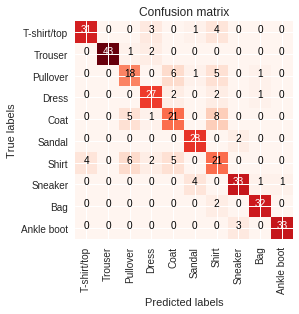

In [0]:
d_valid = eval_model(stack_ensemble_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierKFold","svm")

Accuracy: 0.8076
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1000
           1       0.97      0.94      0.95      1000
           2       0.74      0.66      0.70      1000
           3       0.76      0.88      0.81      1000
           4       0.72      0.75      0.73      1000
           5       0.89      0.88      0.88      1000
           6       0.53      0.57      0.55      1000
           7       0.85      0.86      0.86      1000
           8       0.95      0.92      0.93      1000
           9       0.89      0.91      0.90      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix


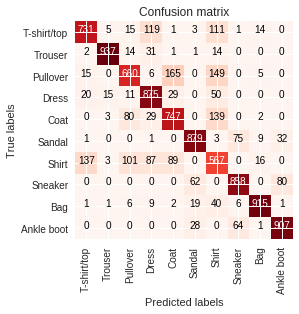

In [0]:
d_test = eval_model(stack_ensemble_kfold_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierKFold","svm")

In [0]:
stack_ensemble_clf = StackedEnsembleClassifier(stack_layer_classifier_type = "tree")

In [0]:
stack_ensemble_clf.fit(X_train,y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='tree')

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        39
           1       0.93      0.93      0.93        46
           2       0.56      0.45      0.50        31
           3       0.74      0.81      0.78        32
           4       0.61      0.57      0.59        35
           5       0.85      0.73      0.79        30
           6       0.38      0.53      0.44        38
           7       0.85      0.85      0.85        39
           8       0.89      0.91      0.90        34
           9       1.00      0.86      0.93        36

   micro avg       0.75      0.75      0.75       360
   macro avg       0.76      0.74      0.75       360
weighted avg       0.76      0.75      0.75       360

Confusion Matrix


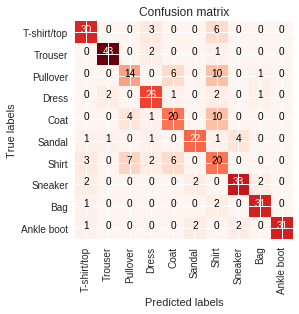

In [0]:
d_valid = eval_model(stack_ensemble_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifier","tree")

Accuracy: 0.7682
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1000
           1       0.93      0.95      0.94      1000
           2       0.73      0.58      0.65      1000
           3       0.76      0.85      0.80      1000
           4       0.71      0.63      0.67      1000
           5       0.92      0.73      0.82      1000
           6       0.43      0.61      0.51      1000
           7       0.82      0.88      0.85      1000
           8       0.92      0.89      0.91      1000
           9       0.92      0.87      0.90      1000

   micro avg       0.77      0.77      0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Confusion Matrix


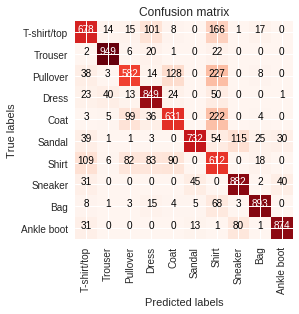

In [0]:
d_test = eval_model(stack_ensemble_clf,X_test,Y_test,d_test,"StackedEnsembleClassifier","tree")

In [0]:
stack_ensemble_holdout_clf = StackedEnsembleClassifierHoldOut(stack_layer_classifier_type = "tree")

In [0]:
stack_ensemble_holdout_clf.fit(X_train,y_train)

StackedEnsembleClassifierHoldOut(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 stack_layer_classifier_type='tree')

Accuracy: 0.7444444444444445
              precision    recall  f1-score   support

           0       0.71      0.87      0.78        39
           1       1.00      0.96      0.98        46
           2       0.67      0.52      0.58        31
           3       0.92      0.72      0.81        32
           4       0.50      0.49      0.49        35
           5       0.90      0.63      0.75        30
           6       0.40      0.53      0.45        38
           7       0.71      0.95      0.81        39
           8       0.88      0.88      0.88        34
           9       1.00      0.78      0.88        36

   micro avg       0.74      0.74      0.74       360
   macro avg       0.77      0.73      0.74       360
weighted avg       0.77      0.74      0.75       360

Confusion Matrix


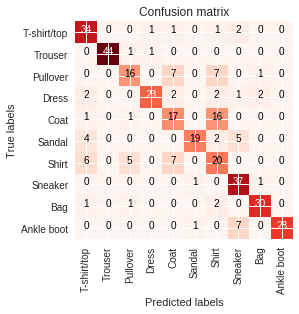

In [0]:
d_valid = eval_model(stack_ensemble_holdout_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierHoldOut","tree")

Accuracy: 0.7358
              precision    recall  f1-score   support

           0       0.60      0.73      0.66      1000
           1       0.94      0.93      0.94      1000
           2       0.75      0.57      0.65      1000
           3       0.86      0.73      0.79      1000
           4       0.63      0.58      0.60      1000
           5       0.92      0.66      0.77      1000
           6       0.41      0.53      0.46      1000
           7       0.64      0.94      0.76      1000
           8       0.94      0.89      0.91      1000
           9       0.95      0.80      0.86      1000

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.76      0.74      0.74     10000
weighted avg       0.76      0.74      0.74     10000

Confusion Matrix


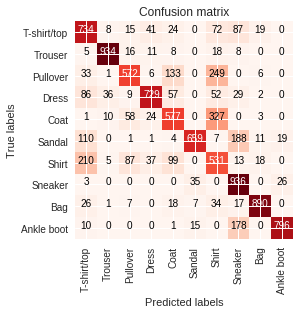

In [0]:
d_test = eval_model(stack_ensemble_holdout_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierHoldOut","tree")

In [0]:
stack_ensemble_kfold_clf = StackedEnsembleClassifierKFold(stack_layer_classifier_type = "tree")

In [0]:
stack_ensemble_kfold_clf.fit(X_train,y_train)

StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                base_estimator_types=['svm', 'logreg', 'tree'], folds=3,
                stack_layer_classifier_type='tree')

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        39
           1       0.93      0.93      0.93        46
           2       0.56      0.45      0.50        31
           3       0.74      0.81      0.78        32
           4       0.61      0.57      0.59        35
           5       0.85      0.73      0.79        30
           6       0.38      0.53      0.44        38
           7       0.85      0.85      0.85        39
           8       0.89      0.91      0.90        34
           9       1.00      0.86      0.93        36

   micro avg       0.75      0.75      0.75       360
   macro avg       0.76      0.74      0.75       360
weighted avg       0.76      0.75      0.75       360

Confusion Matrix


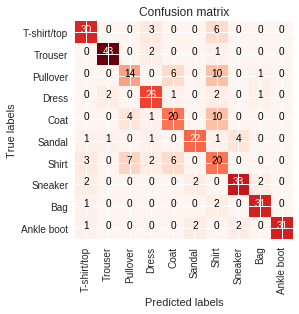

In [0]:
d_valid = eval_model(stack_ensemble_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierKFold","tree")

Accuracy: 0.7055
              precision    recall  f1-score   support

           0       0.75      0.55      0.64      1000
           1       0.95      0.94      0.95      1000
           2       0.55      0.66      0.60      1000
           3       0.76      0.81      0.78      1000
           4       0.55      0.63      0.59      1000
           5       0.69      0.90      0.78      1000
           6       0.49      0.40      0.44      1000
           7       0.65      0.68      0.67      1000
           8       0.96      0.89      0.92      1000
           9       0.76      0.59      0.67      1000

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000

Confusion Matrix


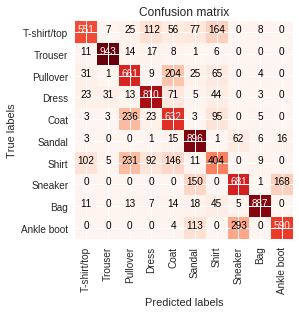

In [0]:
d_test = eval_model(stack_ensemble_kfold_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierKFold","tree")

# Observation

In [0]:
x = PrettyTable()
report(["Base Layer Type", "Stack Layer", "Validation Accuracy", "Test Accuracy"],d_valid,d_test,x )

+----------------------------------+-------------+---------------------+---------------+
|         Base Layer Type          | Stack Layer | Validation Accuracy | Test Accuracy |
+----------------------------------+-------------+---------------------+---------------+
|    StackedEnsembleClassifier     |    logreg   |  0.7888888888888889 |     0.8076    |
| StackedEnsembleClassifierHoldOut |    logreg   |  0.7666666666666667 |     0.7871    |
|  StackedEnsembleClassifierKFold  |    logreg   |  0.7722222222222223 |     0.8005    |
|    StackedEnsembleClassifier     |     svm     |  0.7972222222222223 |     0.8111    |
| StackedEnsembleClassifierHoldOut |     svm     |  0.7611111111111111 |     0.7833    |
|  StackedEnsembleClassifierKFold  |     svm     |  0.7972222222222223 |     0.8076    |
|    StackedEnsembleClassifier     |     tree    |         0.75        |     0.7682    |
| StackedEnsembleClassifierHoldOut |     tree    |  0.7444444444444445 |     0.7358    |
|  StackedEnsembleCla

# Inference

1.  StackedEnsembleClassifier with svm as stack layer has the highest test set accuracy of 81.1%.
2.   We have used accuracy as evaluation measure since Fashion mnist is a balanced dataset.




## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

In [0]:
d_valid = dict()
d_test = dict()

In [0]:
stens_clf = StackedEnsembleClassifier()

In [192]:
stens_clf.fit(X_train,y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='logreg')

Accuracy: 80.27777777777779
              precision    recall  f1-score   support

           0       0.86      0.79      0.83        39
           1       0.98      0.93      0.96        46
           2       0.59      0.55      0.57        31
           3       0.79      0.84      0.82        32
           4       0.65      0.69      0.67        35
           5       0.88      0.97      0.92        30
           6       0.50      0.53      0.51        38
           7       0.91      0.82      0.86        39
           8       0.91      0.94      0.93        34
           9       0.92      0.94      0.93        36

   micro avg       0.80      0.80      0.80       360
   macro avg       0.80      0.80      0.80       360
weighted avg       0.81      0.80      0.80       360

Confusion Matrix
StackedEnsembleClassifier


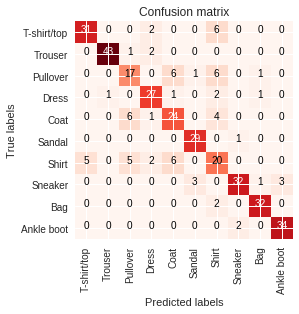

In [193]:
d_valid = eval_model(stens_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifier","logreg")

Accuracy: 80.71000000000001
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1000
           1       0.94      0.96      0.95      1000
           2       0.70      0.71      0.71      1000
           3       0.79      0.87      0.83      1000
           4       0.73      0.68      0.70      1000
           5       0.91      0.86      0.88      1000
           6       0.55      0.56      0.55      1000
           7       0.84      0.86      0.85      1000
           8       0.95      0.93      0.94      1000
           9       0.89      0.92      0.90      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix
StackedEnsembleClassifier


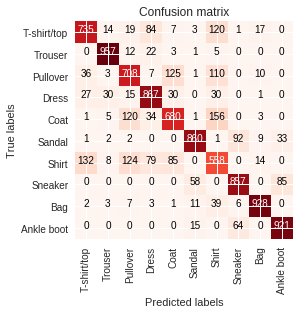

In [196]:
d_test = eval_model(stens_clf,X_test,Y_test,d_test,"StackedEnsembleClassifier","logreg")

In [0]:
stenshld_clf = StackedEnsembleClassifierHoldOut()

In [162]:
stenshld_clf.fit(X_train,y_train)

StackedEnsembleClassifierHoldOut(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 stack_layer_classifier_type='logreg')

Accuracy: 75.55555555555556
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        39
           1       0.98      0.96      0.97        46
           2       0.59      0.55      0.57        31
           3       0.79      0.81      0.80        32
           4       0.57      0.57      0.57        35
           5       0.82      0.93      0.87        30
           6       0.33      0.39      0.36        38
           7       0.85      0.87      0.86        39
           8       0.91      0.88      0.90        34
           9       0.97      0.89      0.93        36

   micro avg       0.76      0.76      0.76       360
   macro avg       0.76      0.75      0.76       360
weighted avg       0.77      0.76      0.76       360

Confusion Matrix
StackedEnsembleClassifierHoldOut


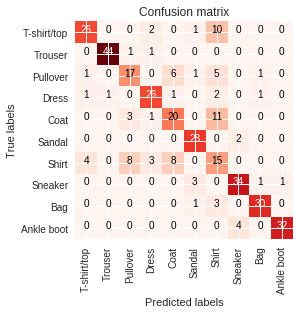

In [197]:
d_valid = eval_model(stenshld_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierHoldOut","logreg")

Accuracy: 79.0
              precision    recall  f1-score   support

           0       0.82      0.65      0.73      1000
           1       0.93      0.95      0.94      1000
           2       0.71      0.68      0.69      1000
           3       0.79      0.85      0.82      1000
           4       0.74      0.60      0.66      1000
           5       0.88      0.87      0.88      1000
           6       0.48      0.64      0.55      1000
           7       0.81      0.85      0.83      1000
           8       0.94      0.93      0.93      1000
           9       0.89      0.88      0.89      1000

   micro avg       0.79      0.79      0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

Confusion Matrix
StackedEnsembleClassifierHoldOut


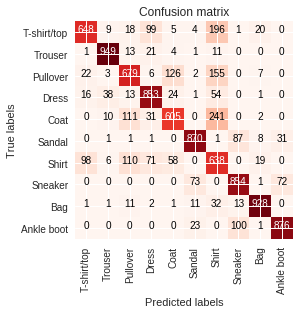

In [198]:
d_test = eval_model(stenshld_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierHoldOut","logreg")

In [0]:
stenskf_clf = StackedEnsembleClassifierKFold()

In [164]:
stenskf_clf.fit(X_train,y_train)

StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                base_estimator_types=['svm', 'logreg', 'tree'], folds=3,
                stack_layer_classifier_type='logreg')

Accuracy: 76.38888888888889
              precision    recall  f1-score   support

           0       0.91      0.79      0.85        39
           1       0.96      0.93      0.95        46
           2       0.55      0.58      0.56        31
           3       0.79      0.84      0.82        32
           4       0.56      0.51      0.54        35
           5       0.77      0.90      0.83        30
           6       0.41      0.45      0.43        38
           7       0.83      0.87      0.85        39
           8       0.91      0.91      0.91        34
           9       0.94      0.81      0.87        36

   micro avg       0.76      0.76      0.76       360
   macro avg       0.76      0.76      0.76       360
weighted avg       0.77      0.76      0.77       360

Confusion Matrix
StackedEnsembleClassifierKFold


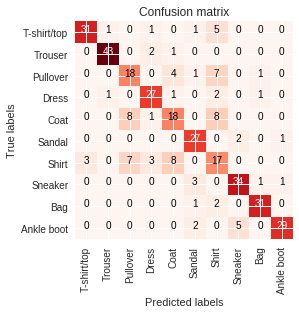

In [199]:
d_valid = eval_model(stenskf_clf,X_valid,y_valid,d_valid,"StackedEnsembleClassifierKFold","logreg")

Accuracy: 80.13
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1000
           1       0.92      0.96      0.94      1000
           2       0.71      0.68      0.69      1000
           3       0.77      0.86      0.81      1000
           4       0.72      0.68      0.70      1000
           5       0.88      0.88      0.88      1000
           6       0.53      0.54      0.53      1000
           7       0.85      0.86      0.86      1000
           8       0.94      0.94      0.94      1000
           9       0.90      0.90      0.90      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Confusion Matrix
StackedEnsembleClassifierKFold


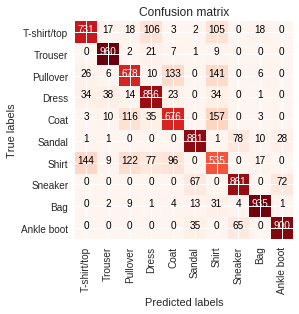

In [200]:
d_test = eval_model(stenskf_clf,X_test,Y_test,d_test,"StackedEnsembleClassifierKFold","logreg")

In [142]:
simple_tree = tree.DecisionTreeClassifier()

simple_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy: 68.88888888888889
              precision    recall  f1-score   support

           0       0.72      0.59      0.65        39
           1       0.91      0.93      0.92        46
           2       0.39      0.42      0.41        31
           3       0.64      0.72      0.68        32
           4       0.59      0.57      0.58        35
           5       0.68      0.77      0.72        30
           6       0.38      0.37      0.37        38
           7       0.82      0.69      0.75        39
           8       0.78      0.85      0.82        34
           9       0.89      0.92      0.90        36

   micro avg       0.69      0.69      0.69       360
   macro avg       0.68      0.68      0.68       360
weighted avg       0.69      0.69      0.69       360

Confusion Matrix
DecisionTreeClassifier


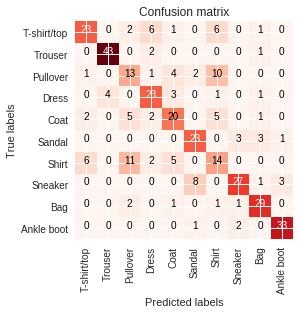

In [201]:
d_valid = eval_model(simple_tree,X_valid,y_valid,d_valid,"DecisionTreeClassifier","NA")

Accuracy: 69.76
              precision    recall  f1-score   support

           0       0.71      0.64      0.67      1000
           1       0.82      0.91      0.87      1000
           2       0.62      0.61      0.62      1000
           3       0.69      0.71      0.70      1000
           4       0.58      0.57      0.57      1000
           5       0.70      0.78      0.74      1000
           6       0.44      0.41      0.42      1000
           7       0.75      0.73      0.74      1000
           8       0.80      0.79      0.79      1000
           9       0.84      0.83      0.83      1000

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.69      0.70      0.70     10000
weighted avg       0.69      0.70      0.70     10000

Confusion Matrix
DecisionTreeClassifier


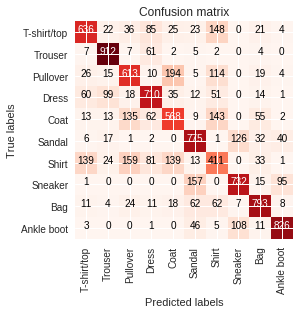

In [202]:
d_test = eval_model(simple_tree,X_test,Y_test,d_test,"DecisionTreeClassifier","NA")

**BAGGING**

In [150]:
Simple_b_model = ensemble.RandomForestClassifier()
Simple_b_model.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy: 100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        46
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        32
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        38
           7       1.00      1.00      1.00        39
           8       1.00      1.00      1.00        34
           9       1.00      1.00      1.00        36

   micro avg       1.00      1.00      1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360

Confusion Matrix
RandomForestClassifier


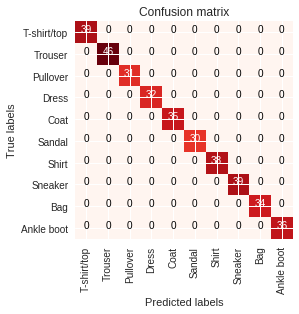

In [203]:
d_valid = eval_model(Simple_b_model,X_valid,y_valid,d_valid,"RandomForestClassifier","NA")

Accuracy: 78.82000000000001
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1000
           1       0.92      0.95      0.94      1000
           2       0.64      0.68      0.66      1000
           3       0.77      0.85      0.81      1000
           4       0.67      0.69      0.68      1000
           5       0.86      0.87      0.86      1000
           6       0.61      0.43      0.50      1000
           7       0.82      0.83      0.82      1000
           8       0.93      0.92      0.92      1000
           9       0.88      0.87      0.87      1000

   micro avg       0.79      0.79      0.79     10000
   macro avg       0.78      0.79      0.78     10000
weighted avg       0.78      0.79      0.78     10000

Confusion Matrix
RandomForestClassifier


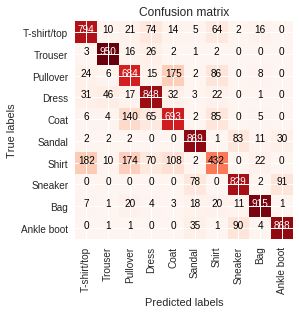

In [204]:
d_test = eval_model(Simple_b_model,X_test,Y_test,d_test,"RandomForestClassifier","NA")

**Grid Search for Decision Tree**

In [214]:
# Set up the parameter grid to seaerch for simple decision tree
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 20, 3)), \
             'min_samples_split': [50] }

# Perform the search
my_tuned_tree = GridSearchCV(simple_tree, \
                                param_grid, cv=5, \
                            return_train_score=True)
my_tuned_tree.fit(X, Y)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
display(my_tuned_tree.best_score_)

Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 50}

0.6961111111111111

Accuracy: 71.08
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      1000
           1       0.88      0.87      0.87      1000
           2       0.65      0.60      0.63      1000
           3       0.66      0.75      0.70      1000
           4       0.59      0.57      0.58      1000
           5       0.70      0.81      0.75      1000
           6       0.50      0.47      0.48      1000
           7       0.76      0.78      0.77      1000
           8       0.86      0.76      0.81      1000
           9       0.89      0.81      0.85      1000

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

Confusion Matrix



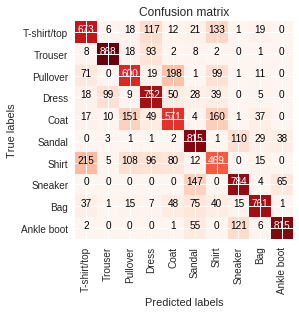

In [215]:
eval_model(my_tuned_tree,X_test,Y_test)

**Grid Search for Random Forest**

In [158]:
# Set up the parameter grid to seaerch for randomforest model
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 20, 3)), \
             'min_samples_split': [50] }

# Perform the search
my_btuned_tree = GridSearchCV(Simple_b_model, \
                                param_grid, cv=5, verbose = 0, \
                            return_train_score=True)
my_btuned_tree.fit(X, Y)
print("Best parameters set found on development set:")
display(my_btuned_tree.best_params_)
display(my_btuned_tree.best_score_)


Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 50}

0.775

Accuracy: 78.49000000000001
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1000
           1       0.94      0.92      0.93      1000
           2       0.68      0.66      0.67      1000
           3       0.66      0.90      0.76      1000
           4       0.65      0.72      0.68      1000
           5       0.92      0.85      0.88      1000
           6       0.72      0.37      0.49      1000
           7       0.84      0.83      0.83      1000
           8       0.88      0.93      0.91      1000
           9       0.84      0.91      0.88      1000

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Confusion Matrix


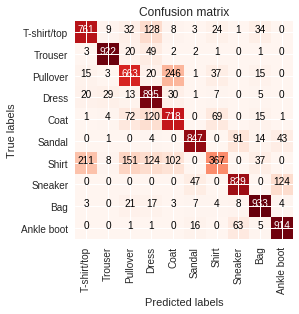

In [156]:
eval_model(my_btuned_tree,X_test,Y_test)

# Observation

In [205]:
x = PrettyTable()
report(["Base Layer Type", "Stack Layer", "Validation Accuracy", "Test Accuracy"],d_valid,d_test,x )

+----------------------------------+-------------+---------------------+-------------------+
|         Base Layer Type          | Stack Layer | Validation Accuracy |   Test Accuracy   |
+----------------------------------+-------------+---------------------+-------------------+
|    StackedEnsembleClassifier     |    logreg   |  80.27777777777779  | 80.71000000000001 |
| StackedEnsembleClassifierHoldOut |    logreg   |  75.55555555555556  |        79.0       |
|  StackedEnsembleClassifierKFold  |    logreg   |  76.38888888888889  |       80.13       |
|      DecisionTreeClassifier      |      NA     |  68.88888888888889  |       69.76       |
|      RandomForestClassifier      |      NA     |        100.0        | 78.82000000000001 |
+----------------------------------+-------------+---------------------+-------------------+


**Inference**

1. In the 4th task comparing the stacked ensemble model with single decision tree and ensemble based bagging we observe that the accuracy of the stacked model is more. 

2. Also when applying grid search to single decision tree and ensemble based bagging we see that using the best params, there was slight increase in the accuracy of the these two models on the test set but as compared to the stacked models it was less.

## Task 5: Implement the StackedEnsembleOneVsOne Class

In [0]:
#divides the dataset into dictionaries based on combinations provided 
def classDictionary(x,y,classes):
        df = pd.DataFrame(data = x)
        df['label'] = y
        d = {}
        for i in classes:
            df0 = df[df.loc[:]["label"] == i]
            d[i] = df0
        return d

In [0]:
#specialist ensemble technique to train the data on combinations of two
class StackedEnsembleClassifierOneVsOne(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "tree"):
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        
    
        
    

    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.classifiers_ = list()
        comb = combinations(self.classes_, 2)
        comb = list(comb)# contains list of all possible combinations based on classes
        
        
        for i in range(len(comb)):
            k = 0
            for t in self.base_estimator_types:
                self.base_estimator_type_list.append(self.base_estimator_types[k])      
                c = create_classifier(self.base_estimator_types[k], tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
                k += 1

            
                
        self.n_estimators_ = len(self.classifiers_)
        
        
        d = classDictionary(X,y,self.classes_)# calls the function classDictionary
        
        
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = np.array([]) #(dtype = float)
        
        classifier = 0
        j = 0
        
        for i in comb:# iterates through every possible combination
            
            k,v = i
            df0 = pd.concat([d[k],d[v]])
            X_train = df0[df0.columns[:-1]]
            y_train = np.array(df0["label"])
            X_stack_train_fold = None
            #self.y_stack_train = np.c_[self.y_stack_train, y_train]
            self.y_stack_train =  y
            #code to train the specialist base layer
            j = 0 # variable to observe count to add models in each base layer
            while (classifier <(len(self.classifiers_))): 
                if j >= (len(self.base_estimator_types)):
                    break
                else:
                    j += 1
                X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)
                self.classifiers_[classifier].fit(X_train_samp, y_train_samp)
                y_pred = self.classifiers_[classifier].predict_proba(X)
                try:
                    X_stack_train_fold = np.c_[X_stack_train_fold, y_pred]
                except ValueError:
                    X_stack_train_fold = y_pred
                classifier += 1
                
            try:
                self.X_stack_train = np.c_[self.X_stack_train, X_stack_train_fold]
            except ValueError:
                self.X_stack_train = X_stack_train_fold
                
            
            
            self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))
            self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        return self
       
        
    def predict(self, X):
        
        check_is_fitted(self, ['stack_layer_classifier_'])
        X = check_array(X)
        X_stack_queries = None
        
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
                
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    
    
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

In [0]:
clf = StackedEnsembleClassifierOneVsOne()

In [77]:
clf.fit(X_train,y_train)

StackedEnsembleClassifierOneVsOne(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 stack_layer_classifier_type='tree')

Accuracy: 73.05555555555556
              precision    recall  f1-score   support

           0       0.81      0.64      0.71        39
           1       0.95      0.91      0.93        46
           2       0.43      0.58      0.49        31
           3       0.71      0.84      0.77        32
           4       0.60      0.43      0.50        35
           5       0.75      1.00      0.86        30
           6       0.43      0.53      0.48        38
           7       0.91      0.82      0.86        39
           8       0.90      0.76      0.83        34
           9       0.93      0.78      0.85        36

   micro avg       0.73      0.73      0.73       360
   macro avg       0.74      0.73      0.73       360
weighted avg       0.75      0.73      0.73       360

Confusion Matrix


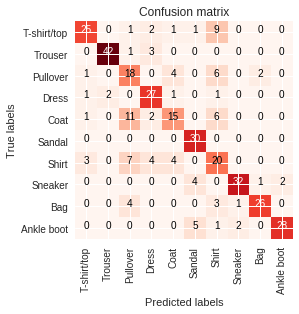

In [87]:
eval_model(clf,X_valid, y_valid)

Accuracy: 76.53999999999999
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1000
           1       0.91      0.95      0.93      1000
           2       0.62      0.66      0.64      1000
           3       0.72      0.82      0.76      1000
           4       0.69      0.52      0.59      1000
           5       0.84      0.89      0.86      1000
           6       0.50      0.59      0.54      1000
           7       0.87      0.83      0.85      1000
           8       0.94      0.85      0.89      1000
           9       0.88      0.86      0.87      1000

   micro avg       0.77      0.77      0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Confusion Matrix


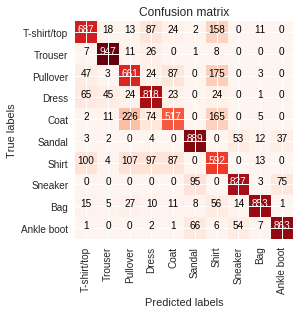

In [84]:
eval_model(clf,X_test,Y_test)

## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

In [0]:
d_bestparam = {}
d_bestscore = {}
d_testscore = {}

In [0]:
X = df[df.columns[1:]]
Y = np.array(df["label"])

In [0]:
X = X/255

In [0]:
param_grid = [
 {"base_estimator_types" : [("svm", "logreg", "tree") , ("svm", "logreg" , "randomforest")],"stack_layer_classifier_type" : ["svm", "logreg","randomforest"]}]

In [0]:
onevsone_clf = StackedEnsembleClassifierOneVsOne()

In [0]:
onevsone_clf_tune = GridSearchCV(onevsone_clf, param_grid)

In [103]:
onevsone_clf_tune.fit(X,Y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=StackedEnsembleClassifierOneVsOne(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 stack_layer_classifier_type='tree'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'base_estimator_types': [('svm', 'logreg', 'tree'), ('svm', 'logreg', 'randomforest')], 'stack_layer_classifier_type': ['svm', 'logreg', 'randomforest']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [107]:
print("Best parameters set found on development set:")
display(onevsone_clf_tune.best_params_)
display(onevsone_clf_tune.best_score_)

Best parameters set found on development set:


{'base_estimator_types': ('svm', 'logreg', 'randomforest'),
 'stack_layer_classifier_type': 'logreg'}

0.8038888888888889

In [0]:
d_bestparam['StackedEnsembleClassifierOneVsOne'] = onevsone_clf_tune.best_params_
d_bestscore['StackedEnsembleClassifierOneVsOne'] = onevsone_clf_tune.best_score_ * 100

Accuracy: 82.59
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1000
           1       0.94      0.96      0.95      1000
           2       0.73      0.73      0.73      1000
           3       0.80      0.89      0.84      1000
           4       0.76      0.70      0.73      1000
           5       0.94      0.88      0.91      1000
           6       0.61      0.55      0.58      1000
           7       0.87      0.88      0.88      1000
           8       0.94      0.95      0.95      1000
           9       0.87      0.93      0.90      1000

   micro avg       0.83      0.83      0.83     10000
   macro avg       0.82      0.83      0.82     10000
weighted avg       0.82      0.83      0.82     10000

Confusion Matrix


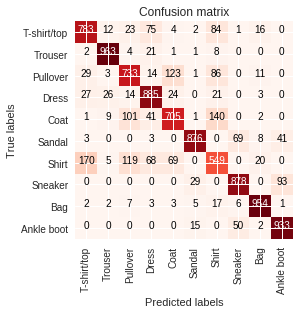

In [108]:
eval_model(onevsone_clf_tune,X_test,Y_test )

In [0]:
d_testscore["StackedEnsembleClassifierOneVsOne"] = 82.59

In [0]:
stackensemble_clf = StackedEnsembleClassifier()

In [0]:
stackensemble_clf_tune = GridSearchCV(stackensemble_clf, param_grid)

In [115]:
stackensemble_clf_tune.fit(X,Y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='logreg'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'base_estimator_types': [('svm', 'logreg', 'tree'), ('svm', 'logreg', 'randomforest')], 'stack_layer_classifier_type': ['svm', 'logreg', 'randomforest']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
d_bestparam['StackedEnsembleClassifier'] = stackensemble_clf_tune.best_params_
d_bestscore['StackedEnsembleClassifier'] = stackensemble_clf_tune.best_score_ * 100

Accuracy: 82.91
              precision    recall  f1-score   support

           0       0.81      0.74      0.78      1000
           1       0.96      0.94      0.95      1000
           2       0.75      0.73      0.74      1000
           3       0.78      0.89      0.83      1000
           4       0.75      0.76      0.76      1000
           5       0.93      0.88      0.91      1000
           6       0.60      0.60      0.60      1000
           7       0.87      0.88      0.87      1000
           8       0.95      0.94      0.94      1000
           9       0.89      0.93      0.91      1000

   micro avg       0.83      0.83      0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix


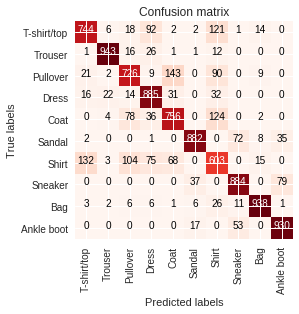

In [119]:
eval_model(stackensemble_clf_tune,X_test,Y_test )

In [0]:
d_testscore["StackedEnsembleClassifier"] = 82.91

In [0]:
stackensemble_holdout_clf = StackedEnsembleClassifierHoldOut()

In [0]:
stackensemble_holdout_clf_tune = GridSearchCV(stackensemble_holdout_clf, param_grid)

In [122]:
stackensemble_holdout_clf_tune.fit(X,Y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=StackedEnsembleClassifierHoldOut(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 stack_layer_classifier_type='logreg'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'base_estimator_types': [('svm', 'logreg', 'tree'), ('svm', 'logreg', 'randomforest')], 'stack_layer_classifier_type': ['svm', 'logreg', 'randomforest']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
d_bestparam['StackedEnsembleClassifierHoldOut'] = stackensemble_holdout_clf_tune.best_params_
d_bestscore['StackedEnsembleClassifierHoldOut'] = stackensemble_holdout_clf_tune.best_score_ * 100

Accuracy: 81.94
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1000
           1       0.94      0.95      0.95      1000
           2       0.73      0.70      0.72      1000
           3       0.78      0.88      0.83      1000
           4       0.73      0.75      0.74      1000
           5       0.91      0.89      0.90      1000
           6       0.58      0.56      0.57      1000
           7       0.88      0.85      0.86      1000
           8       0.94      0.94      0.94      1000
           9       0.87      0.93      0.90      1000

   micro avg       0.82      0.82      0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Confusion Matrix


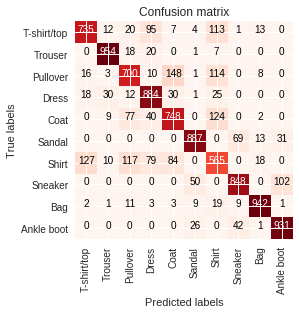

In [134]:
eval_model(stackensemble_holdout_clf_tune,X_test,Y_test )

In [0]:
d_testscore["StackedEnsembleClassifierHoldOut"] = 81.94

In [0]:
stackensemble_kfold_clf = StackedEnsembleClassifierKFold()

In [0]:
stackensemble_kfold_clf_tune = GridSearchCV(stackensemble_kfold_clf, param_grid)

In [125]:
stackensemble_kfold_clf_tune.fit(X,Y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                base_estimator_types=['svm', 'logreg', 'tree'], folds=3,
                stack_layer_classifier_type='logreg'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'base_estimator_types': [('svm', 'logreg', 'tree'), ('svm', 'logreg', 'randomforest')], 'stack_layer_classifier_type': ['svm', 'logreg', 'randomforest']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
d_bestparam['StackedEnsembleClassifierKFold'] = stackensemble_kfold_clf_tune.best_params_
d_bestscore['StackedEnsembleClassifierKFold'] = stackensemble_kfold_clf_tune.best_score_ * 100

Accuracy: 83.47
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1000
           1       0.94      0.96      0.95      1000
           2       0.75      0.73      0.74      1000
           3       0.79      0.88      0.83      1000
           4       0.76      0.76      0.76      1000
           5       0.91      0.92      0.92      1000
           6       0.61      0.57      0.59      1000
           7       0.92      0.87      0.89      1000
           8       0.94      0.95      0.95      1000
           9       0.89      0.94      0.92      1000

   micro avg       0.83      0.83      0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix


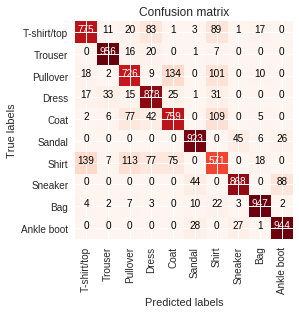

In [127]:
eval_model(stackensemble_kfold_clf_tune,X_test,Y_test )

In [0]:
d_testscore["StackedEnsembleClassifierKFold"] = 83.47

In [0]:
def reportensemble(header, d, d1,d2, table):
  table.field_names = header
  for k,v in d.items():
    table.add_row([k,v,d1[k],d2[k]])
  
  print(table)
    

# Observation

In [141]:
y = PrettyTable()
reportensemble(["Ensemble Type", "Best Param", "Training Score", "Test Score"],d_bestparam,d_bestscore,d_testscore,y )

+-----------------------------------+------------------------------------------------------------------------------------------------------+-------------------+------------+
|           Ensemble Type           |                                              Best Param                                              |   Training Score  | Test Score |
+-----------------------------------+------------------------------------------------------------------------------------------------------+-------------------+------------+
| StackedEnsembleClassifierOneVsOne | {'base_estimator_types': ('svm', 'logreg', 'randomforest'), 'stack_layer_classifier_type': 'logreg'} | 80.38888888888889 |   82.59    |
|     StackedEnsembleClassifier     |  {'base_estimator_types': ('svm', 'logreg', 'randomforest'), 'stack_layer_classifier_type': 'svm'}   | 81.44444444444444 |   82.91    |
|  StackedEnsembleClassifierHoldOut | {'base_estimator_types': ('svm', 'logreg', 'randomforest'), 'stack_layer_classifier_type': '

**Inference**


1.    We can observe that StackedEnsembleClassifierKFold has the best Test Score while StackedEnsembleClassifierHoldOut has the least score.
2.   Difference in the accuracy is not much when compared to simple models but this might change if we use the whole dataset







## Task 7 Reflect on the Performance of the Different Models Evaluated

*Write your reflection here (max 300 words)*

1.	We have evaluated a fraction of MNIST dataset (0.02) on two simple models and three stacked models. 

2.	Overall the StackedEnsembleClassifier with best params seems to obtain most accuracy on the dataset while the other models differ by 3-4 % in overall accuracy achieved. 

3.	In stacking ensemble with more models in the base layer and also the stack layer the training time increases and also there is also requirement for powerful computation which will increase the cost. For example, in case of one vs one classifier we had 45 layers in base with each layer consisting of 3 classifiers so we had 135 classifiers training on part of dataset and predicting the whole dataset which requires immense computational power and also the complexity of model increases in this case. Whereas when compared to simple models the difference in accuracy is about 2-3% and the computational requirement as well as model complexity is very less when compared to ensembles but there might be a difference in the accuracy when we consider the whole dataset since the ensemble have more models to learn from the data when compared to simple models their prediction might increase with more data but there will also be an increase in the complexity as well as the computational power.

4.	In the 4th task comparing the stacked ensemble model with single decision tree and ensemble based bagging we observe that the accuracy of the stacked model is more. Also when applying grid search to single decision tree and ensemble based bagging we see that using the best params we found that there was slight increase in the accuracy of the these two models on the test set but as compared to the stacked models it was less.  

5.	Overall we can say that ensemble stacking models should be used in case we have good computational power and huge data to train the stacking models